# Base Editing (BE) Coverage analysis

- This notebook provides a quantification of the capabilities of base editing to model mutations present in the MSK IMPACT dataset.
    - Assumptions:
        - Using an NGG PAM site for the base editor
        - ideal/high efficiency editing window is +4 to +8 (inclusive) in the protospacer
        - I look at both adenine and cytosine base editors

For more information regarding collection MSK IMPACT methods, etc., see: 
- https://www.mskcc.org/msk-impact
- https://datacatalog.mskcc.org/dataset/10438

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv

In [2]:
filepath = '/Volumes/Sam_G_SSD/2020-06-16-MSK-IMPACT_EDITED.txt'
impact_data = pd.read_csv(filepath, sep='\t')

/var/folders/5g/xxjcy2g531n02hnyb6d8qdsr0000gn/T/ipykernel_32865/836307472.py:2: DtypeWarning: Columns (45,48,88) have mixed types. Specify dtype option on import or set low_memory=False.
  impact_data = pd.read_csv(filepath, sep='\t')


In [3]:
impact_data

,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Consequence,Variant_Classification,...,VARIANT_CLASS,all_effects,amino_acid_change,cDNA_Change,cDNA_position,cdna_change,comments,n_depth,t_depth,transcript
0,BRCA2,675,MSKCC,GRCh37,13,32937315,32937315,+,splice_acceptor_variant,Splice_Site,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BRCA2,0,MSKCC,37,13,32914437,32914438,+,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MUTYH,4595,MSKCC,GRCh37,1,45798475,45798475,+,missense_variant,Missense_Mutation,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BRCA2,675,MSKCC,GRCh37,13,32893302,32893302,+,frameshift_variant,Frame_Shift_Ins,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BRCA1,0,MSKCC,37,17,41251824,41251825,+,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422817,SMARCA4,6597,MSKCC,GRCh37,19,11144132,11144132,+,missense_variant,Missense_Mutation,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
422818,BRAF,673,MSKCC,GRCh37,7,140453149,140453149,+,missense_variant,Missense_Mutation,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
422819,NRAS,4893,MSKCC,GRCh37,1,115258747,115258747,+,missense_variant,Missense_Mutation,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
422820,TERT,7015,MSKCC,GRCh37,5,1295521,1295521,+,upstream_gene_variant,5'Flank,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#list of unique genes tested
unique_genes = np.unique(np.asarray(impact_data['Hugo_Symbol']))
print('There are ' + str(len(unique_genes)) + ' unique genes observed')

There are 594 unique genes observed


# Loading in reference genome and annotation files

- Annotation file generated in Genome Processing notebook
- Downloading reference sequence from: https://www.ncbi.nlm.nih.gov/assembly/GCF_000001405.26/ (assembly GRCh38)
- GRCh37: https://www.ncbi.nlm.nih.gov/assembly/GCF_000001405.25


In [6]:
from Bio import SeqIO
import gzip

In [7]:
#MSK IMPACT dataset uses GrCh37 build
np.unique(np.asarray(impact_data['NCBI_Build']))

array(['37', 'GRCh37'], dtype=object)

In [8]:
file = '/Volumes/Sam_G_SSD/GRCh37/ncbi-genomes-2022-03-17/GCF_000001405.25_GRCh37.p13_genomic.fna.gz'

with gzip.open(file, "rt") as handle:
    records = list(SeqIO.parse(handle, "fasta")) #about 4 Gb in  memory
    #records = list that contains sequences split up by chromosome (and intrachromosome splits up to some size)

In [9]:
#filtering out alternative sequences to only select consensus matches


wrong = ["alternate", "unplaced", "unlocalized", "patch"]
badlist = []
for key in wrong:
    for i in records:
        ii = i.description
        if key in ii:
            badlist.append(ii)
            
filtered = []
index_list = []
for idx, i in enumerate(records):
    ii = i.description
    if ii not in badlist:
        filtered.append(ii)
        index_list.append(idx)
        
filtered
    

['NC_000001.10 Homo sapiens chromosome 1, GRCh37.p13 Primary Assembly',
 'NC_000002.11 Homo sapiens chromosome 2, GRCh37.p13 Primary Assembly',
 'NC_000003.11 Homo sapiens chromosome 3, GRCh37.p13 Primary Assembly',
 'NC_000004.11 Homo sapiens chromosome 4, GRCh37.p13 Primary Assembly',
 'NC_000005.9 Homo sapiens chromosome 5, GRCh37.p13 Primary Assembly',
 'NC_000006.11 Homo sapiens chromosome 6, GRCh37.p13 Primary Assembly',
 'NC_000007.13 Homo sapiens chromosome 7, GRCh37.p13 Primary Assembly',
 'NC_000008.10 Homo sapiens chromosome 8, GRCh37.p13 Primary Assembly',
 'NC_000009.11 Homo sapiens chromosome 9, GRCh37.p13 Primary Assembly',
 'NC_000010.10 Homo sapiens chromosome 10, GRCh37.p13 Primary Assembly',
 'NC_000011.9 Homo sapiens chromosome 11, GRCh37.p13 Primary Assembly',
 'NC_000012.11 Homo sapiens chromosome 12, GRCh37.p13 Primary Assembly',
 'NC_000013.10 Homo sapiens chromosome 13, GRCh37.p13 Primary Assembly',
 'NC_000014.8 Homo sapiens chromosome 14, GRCh37.p13 Primary A

In [10]:
chromosome = 20
#22 (23-1) = X
#23 (24-1) = Y
#24 (25-1) = mitochondrial DNA
records[index_list[chromosome-1]]

SeqRecord(seq=Seq('NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...NNN'), id='NC_000020.10', name='NC_000020.10', description='NC_000020.10 Homo sapiens chromosome 20, GRCh37.p13 Primary Assembly', dbxrefs=[])

## Loading in gene coordinate information/annotation file

In [11]:
filename1 = '/Users/samgould/Desktop/FSR Lab/2022-03-17/gene_info.csv'
df1 = pd.read_csv(filename1)
df1

,gene,gene_id,transcript_id,chrom,gene_start,gene_end,transcript_start,transcript_end,strand
0,ABL1,ENSG00000097007.13,ENST00000318560.5,chr9,133589333,133763062,133710453,133763062,+
1,AC004906.3,ENSG00000237286.1,ENST00000423194.1,chr7,2983669,2986725,2983669,2986725,+
2,AC008738.1,ENSG00000230259.2,ENST00000425420.2,chr19,33790853,33793430,33790853,33793430,-
3,ACTG1,ENSG00000184009.5,ENST00000575842.1,chr17,79476997,79490873,79477015,79479807,-
4,ACVR1,ENSG00000115170.9,ENST00000263640.3,chr2,158592958,158732374,158592958,158731623,-
...,...,...,...,...,...,...,...,...,...
589,XRCC2,ENSG00000196584.2,ENST00000359321.1,chr7,152341864,152373250,152343589,152373250,-
590,YAP1,ENSG00000137693.9,ENST00000282441.5,chr11,101981192,102104154,101981192,102104154,+
591,YES1,ENSG00000176105.9,ENST00000314574.4,chr18,721588,812547,721748,812239,-
592,ZFHX3,ENSG00000140836.10,ENST00000268489.5,chr16,72816784,73093597,72816784,73082274,-


# Quantifying the degree of coverage for CBE and ABE (using NG PAM)

- should also look at collateral edits in window
- also whether the edit falls within the canonical editing window (e.g. not at -1 relative to PAM)
- base editing guidelines: https://benchling.com/pub/liu-base-editor

## Generating the the boundaries of BE domains

In [23]:
import re

#changing it so that I look +/- 1 kb upstream and downstream of each gene to avoid issues with TERT mutations

def BE_domains_boundaries(gene_name, df1):
    "Marks N in NGG pam sequence with a 1 in the zero array"
    #df1 is the dataframe containing gene sequence information

    gene_chrom = df1[df1['gene']==gene_name]['chrom'].values[0]
    
    if gene_chrom != 'chrX':
        chrom = int(re.search(r'\d+', gene_chrom).group())
    elif gene_chrom=='chrX':
        chrom = 23 #it's number 22, but we subtract 1 below when accessing chromosome file
        #there are no genes in this dataset that fall on Y chromosome -- ignoring

    seq_start = df1[df1['gene']==gene_name]['gene_start'].values[0]
    seq_end = df1[df1['gene']==gene_name]['gene_end'].values[0]

    gene_sequence_1000eitherend = records[index_list[int(chrom)-1]].seq[seq_start-1001: seq_end+1000]
    #gene sequence with 1000 bp buffer on either end to account for prime domains at beginning of gene

    length_seq = len(gene_sequence_1000eitherend)

    #two arrays corresponding to plus and minus end
    zero_array_plus = np.zeros(length_seq)
    zero_array_minus = np.zeros(length_seq)

    #iterate through sequence

    #iterate +- 1000 bp from start/end of gene
    for idx, val in enumerate(gene_sequence_1000eitherend): 
        
        by_twos = gene_sequence_1000eitherend[idx:idx+2]
        by_twos_true = by_twos.upper()
        
        if by_twos_true == 'GG': #find NGGs
            zero_array_plus[idx-1] += 1#add array of ones at appropriate index when NGG is encountered
        
        else:
            continue


    #repeat on negative strand
    comp = gene_sequence_1000eitherend.complement() #taking complement (- strand in same orientation)
    for idx, val in enumerate(comp):
        
        if idx+5 < length_seq: #dealing with boundary issue
        
            by_twos = comp[idx:idx+2]
            by_twos_true = by_twos.upper() #make it upper case

            if by_twos_true == 'GG': #find NGGs
                zero_array_minus[idx+2] += 1#add array of ones at appropriate index when NGG is encountered
                #+5 instead of +4 because we're counting from the back of the NGG due to orientation

            else:
                continue
        
        else:
            continue
    
    #might be weird edge effects but I'm not using the very end of either of these arrays regardless...
    
    return [zero_array_plus,zero_array_minus]

In [27]:
#repeating same process as above
filename1 = '/Users/samgould/Desktop/FSR Lab/2022-03-17/gene_info.csv'
df1 = pd.read_csv(filename1)

unique_genes = np.unique(np.asarray(impact_data['Hugo_Symbol']))
    
rt_len = [] #coverage array for holding information

for gene in unique_genes:

    gene_name = gene

    kkk = BE_domains_boundaries(gene_name, df1)

    rt_len.append(kkk)
        
filepath = '/Users/samgould/Desktop/FSR Lab/2022-06-21/'
np.save(filepath + 'BE_coverage_boundary_NGG_plusminus_1000bp' +'.npy', np.asarray(rt_len))

#these files are provided in the drobox link...no need to run this yourself

/var/folders/5g/xxjcy2g531n02hnyb6d8qdsr0000gn/T/ipykernel_20629/1423816810.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save(filepath + 'BE_coverage_boundary_NGG_plusminus_1000bp' +'.npy', np.asarray(rt_len))


## BE coverage classifier

For CBE and ABE. CBE = C>T. ABE = A>G.

CBE:
- If mutation is C>T: look on plus strand for PAM
- If mutation is G>A: look on minus strand for PAM

ABE:
- If mutation is A>G: look on plus strand for PAM
- If mutations is T>C: look on minus strand for PAM

In [123]:
#need to fix df1 to include all hgvsc

#TERT mutations and some others don't include this information for some reason...
#issue with the MSK IMPACT dataset
hgvsc_list = list(impact_data['HGVSc'])

num_mutations = len(impact_data)
for i in range(num_mutations):

        #get info on current mut
    mut = impact_data.iloc[i]
        
        #getting type of mutations
    mut_type = mut['Variant_Type'] 
        
    if mut_type == 'SNP': #can only edit snps
        
            #then checking what type of mutation it is
        mut_transversion = impact_data.iloc[i]['HGVSc']
            
        if type(mut_transversion) != str:
            #need to add inmissing HGVSc info
            ref = mut['Reference_Allele']
            a1 = mut['Tumor_Seq_Allele1']
            a2 = mut['Tumor_Seq_Allele2']


            if a1 != ref:
                s1 = ref + '>' + a1
                hgvsc_list[i] = s1

            elif a2 != ref:
                s1 = ref + '>' + a2
                hgvsc_list[i] = s1



In [127]:
impact_data['HGVSc']=hgvsc_list #replacing the old hgvsc list

In [128]:
def BEcoverage_classifier(impact_data, df1):
    #load in (1) impact_data, 
    #(2) df containing gene coordinate info
    #(3) length of rt template
    
    filepath_boundary = '/Users/samgould/Desktop/FSR Lab/2022-06-21/BE_coverage_boundary_NGG_plusminus_1000bp.npy'
    #this needs to be changed according to filepath

    BE_domain_boundary = np.load(filepath_boundary, allow_pickle=True)#for plus and minus strand
    
    path = '/Volumes/Sam_G_SSD/human genome GrCh37 IMPACT genes/'
    unique_genes = np.load(path + 'human_impact_genes_NAMES.npy', allow_pickle=True)
    
    #iterate through mutations in IMPACT dataset
    num_mutations = len(impact_data)
    
    #initialize arrays of zeros for holding information about coverage
    ABEproto = np.zeros(num_mutations)
    ABEideal = np.zeros(num_mutations)
    
    CBEproto = np.zeros(num_mutations)
    CBEideal = np.zeros(num_mutations)
    
    #initialize array for holding weird cases with bad location
    outside_domain = []
    snp_unrecorded = []
    
    for i in range(num_mutations):

        #get info on current mut
        mut = impact_data.iloc[i]
        
        #getting type of mutations
        mut_type = mut['Variant_Type'] 
        
        if mut_type == 'SNP': #can only edit snps
        
            #then checking what type of mutation it is
            mut_transversion = impact_data.iloc[i]['HGVSc']
            
            if type(mut_transversion) != str: #check if the SNP is actually recorded
                snp_unrecorded.append(i)                
                
                
            else:

                trans = mut_transversion[-3:]
                t1 = ['C>T','G>A','A>G','T>C'] #mutations that can be encoded with CBE or ABE

                if any(trans in t1 for k in t1):

                    #getting gene and start/end position of mutation
                    gene = mut['Hugo_Symbol']
                    gene_index = list(unique_genes).index(gene) #retrieving index

                    seq_start = df1[df1['gene']==gene]['gene_start'].values[0] 

                    s = mut['Start_Position']
                    e = mut['End_Position']
                    size_mut = (e-s)+1 #size of mutation

                    #re-indexing with start of gene-1001 as position 0 (start of boundary array)
                    start_true = s-(seq_start-1001)
                    end_true = e-(seq_start-1001)+1
             

                    #retrieving the appropriate gene's prime editing domain
                    BE_domain_bound = BE_domain_boundary[gene_index]
                    

                    #first checking for weird boundary misc.
                    if (start_true or end_true)>len(BE_domain_bound[0]):
                        outside_domain.append(i)
                        print('gene_index: ' + str(gene_index))
                        print(i)
                        print(str(start_true) + ' ; ' +str(end_true) + '; len = ' + str(len(BE_domain_bound[0])))

                    else:
                        #first split into CBE and ABE
                        CBE = ['C>T','G>A'] #mutations that can be encoded with CBE or ABE
                        ABE = ['A>G','T>C'] 
                        
                        if any(trans in CBE for k in CBE):

                            if trans=='C>T':
                                plus_end = BE_domain_bound[0] 
                                bound_proto = plus_end[start_true:start_true+21]
                                bound_ideal = plus_end[start_true+13:start_true+18]
                                
                                if sum(bound_proto)>0:
                                    CBEproto[i]+=1
                                if sum(bound_ideal)>0:
                                    CBEideal[i]+=1
                                
                            elif trans=='G>A':
                                minus_end = BE_domain_bound[1] 
                                bound_proto = minus_end[start_true-21:start_true+1]
                                bound_ideal = minus_end[start_true-17:start_true-12]
                                
                                if sum(bound_proto)>0:
                                    CBEproto[i]+=1
                                if sum(bound_ideal)>0:
                                    CBEideal[i]+=1

                                
                        elif any(trans in ABE for k in ABE):
                            
                            if trans=='A>G':                                
                                plus_end = BE_domain_bound[0] 
                                bound_proto = plus_end[start_true:start_true+21]
                                bound_ideal = plus_end[start_true+13:start_true+18]
                                
                                if sum(bound_proto)>0:
                                    ABEproto[i]+=1
                                if sum(bound_ideal)>0:
                                    ABEideal[i]+=1
                                
                            elif trans=='T>C':
                                minus_end = BE_domain_bound[1] 
                                bound_proto = minus_end[start_true-21:start_true+1]
                                bound_ideal = minus_end[start_true-17:start_true-12]
                                
                                if sum(bound_proto)>0:
                                    ABEproto[i]+=1
                                if sum(bound_ideal)>0:
                                    ABEideal[i]+=1

                        
                else:
                    continue
                    
        else: #can only edit SNPs
            continue

    return CBEproto,CBEideal,ABEproto, ABEideal, outside_domain, snp_unrecorded

In [129]:
CBEproto,CBEideal,ABEproto, ABEideal, outside_domain, snp_unrecorded = BEcoverage_classifier(impact_data, df1)



In [132]:
#saving these arrays for later use
filepath = '/Volumes/Sam_G_SSD/BE coverage quant NGG/'
#np.save(filepath + 'CBE_proto.npy', CBEproto)
#np.save(filepath + 'CBE_ideal.npy', CBEideal)
#np.save(filepath + 'ABE_proto.npy', ABEproto)
#np.save(filepath + 'ABE_ideal.npy', ABEideal)
#np.save(filepath + 'snp_unrecorded.npy', snp_unrecorded)


# Figure Making

This is the messy version with pertinent figures generated from the above analysis.

The figures notebook collates all of this information into a single page. 

In [4]:
mut_types= impact_data['Variant_Type'].value_counts()

mut_types

SNP    348145
DEL     49838
INS     17784
DNP      6042
ONP      1011
UNK         1
TNP         1
Name: Variant_Type, dtype: int64

In [5]:
np.asarray(np.round(100*(mut_types[:-2]/sum(mut_types[:-2])),1))

array([82.3, 11.8,  4.2,  1.4,  0.2])

In [6]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica Neue']})

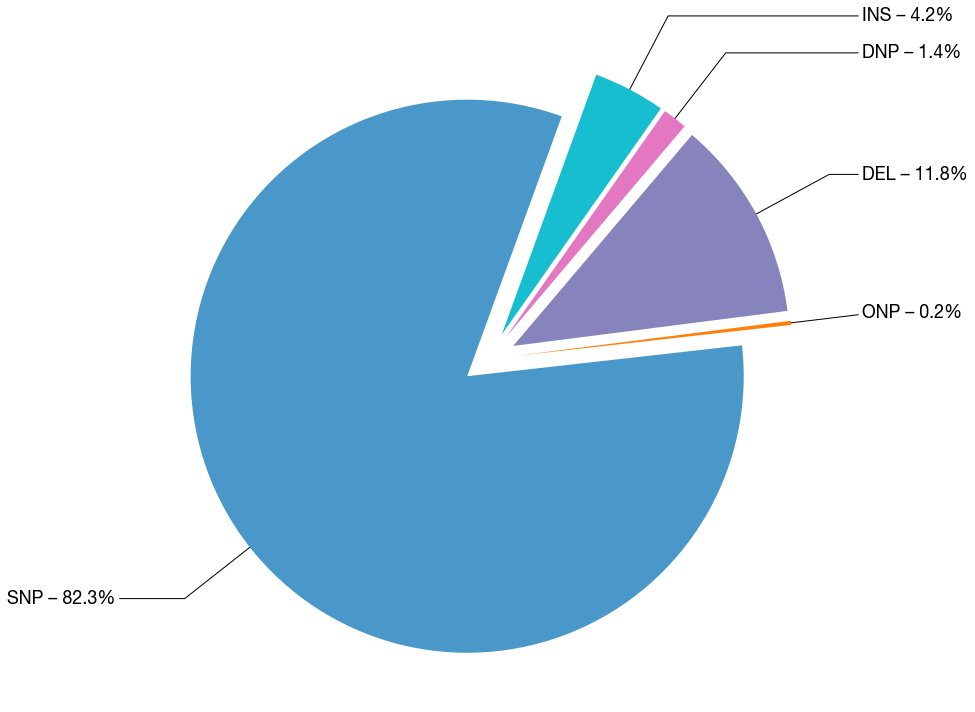

In [11]:
bbox_props=dict(boxstyle='square,pad=0.3',fc ='w',ec='k',lw=0.72)
kw=dict(xycoords='data',textcoords='data',arrowprops=dict(arrowstyle='-'),zorder=0,va='center')

fig1,ax1=plt.subplots(figsize=(15,10))
#labels=["first\n1.8%","second\n1.3%","third\n10.5%","fourth\n13.8%","fifth\n7.8%","sixth\n6.7%","seventh\n9.9%","eighth\n12.2%","ninth\n12.7%","tenth\n10.9%","eleventh\n7.6%","twelfth\n4.8%"]
#values=[1.8,1.3,10.5,13.8,7.8,6.7,9.9,12.2,12.7,10.9,7.6,4.8]
labels = np.asarray(impact_data['Variant_Type'].unique())
perc = np.asarray(np.round(100*(mut_types[:-2]/sum(mut_types[:-2])),1))
labels = [labels[i] + ' – ' + str(perc[i]) + '%' for i in range(len(perc))]
values = mut_types[:-2]

# Add code
annotate_dict = {k:v for k,v in zip(labels, values)}
val = [[x,y] for x,y in zip(sorted(values, reverse=True),sorted(values))]
values1 = sum(val, [])

new_labels = []
for v in values1[:len(values)]:
    for key, value in annotate_dict.items():
        if v == value:
            new_labels.append(key)
c_list = [plt.cm.Blues(0.6), 'tab:orange',plt.cm.Purples(0.6),'tab:pink', 'tab:cyan']
wedges,texts=ax1.pie(values1[:len(values)], explode=[0.1, 0.1, 0.1, 0.1,0.1],colors = c_list, labeldistance=.5,startangle=70)
for i,p in enumerate(wedges):
    ang=(p.theta2-p.theta1)/2. +p.theta1
    y=np.sin(np.deg2rad(ang))
    x=np.cos(np.deg2rad(ang))
    horizontalalignment={-1:"right",1:"left"}[int(np.sign(x))]
    connectionstyle="angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle":connectionstyle})
    ax1.annotate(new_labels[i],fontsize=18,xy=(x, y),xytext=(1.35*np.sign(x),1.4*y),
                horizontalalignment=horizontalalignment,**kw)

plt.tight_layout()
plt.show()
#plt.tight_layout()
#fig1.savefig('mut_type_color_nolabels.png', dpi=300)

In [14]:
#SNP quantification
snps = []
unknown = []
for i in range(len(impact_data)):
    if impact_data.iloc[i]['Variant_Type']=='SNP':
        mut_transversion = impact_data.iloc[i]['HGVSc']
        if type(mut_transversion)==str:
            trans = mut_transversion[-3:]
            snps.append(trans)
        else:
            unknown.append(i)
    else:
        continue

In [15]:
uniq,snp_count = np.unique(np.asarray(snps), return_counts=True)
uniq

array(['A>C', 'A>G', 'A>T', 'C>A', 'C>G', 'C>T', 'G>A', 'G>C', 'G>T',
       'N>A', 'N>C', 'N>G', 'N>T', 'T>A', 'T>C', 'T>G'], dtype='<U3')

In [16]:
snp_count

array([ 7534, 21959, 10598, 18579, 15903, 86527, 92225, 19243, 42934,
           4,     2,     6,    13,  8152, 11422,  7760])

In [17]:
uniq_new = list(uniq[0:9]) + list(uniq[13:])
snp_count_new = list(snp_count[0:9]) + list(snp_count[13:])


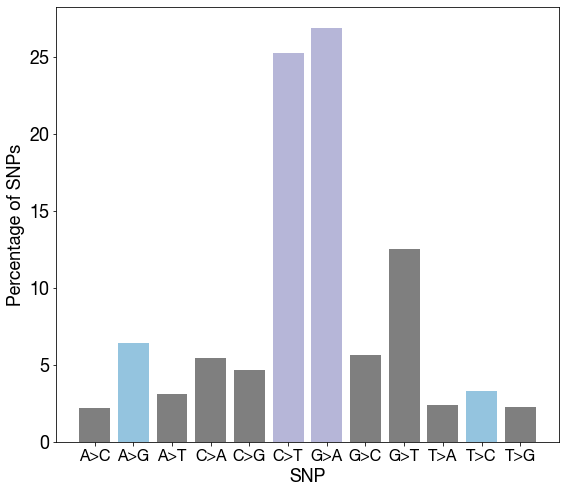

In [77]:
plt.figure(figsize=(9,8))
a, b=[plt.cm.Blues, plt.cm.Purples]
c_list = ['tab:grey', a(0.4),'tab:grey','tab:grey','tab:grey',b(0.4),b(0.4),'tab:grey',
         'tab:grey','tab:grey',a(0.4),'tab:grey']
plt.bar(uniq_new, 100*np.asarray(snp_count_new)/np.sum(np.asarray(snp_count_new)), color=c_list)
plt.xticks(fontsize=16);
plt.yticks(fontsize=18);
plt.ylabel('Percentage of SNPs', fontsize=18);
plt.xlabel('SNP', fontsize=18);
#plt.savefig('SNP_breakdown.png', dpi=300)

In [24]:
labels = ['A>C\nT>G', 'A>G\nT>C', 'A>T\nT>A', 'G>A\nC>T', 'G>C\nC>G', 'G>T\nC>A']

a = ['A>C', 'A>G', 'A>T', 'G>A', 'G>C', 'G>T']
b = ['T>G', 'T>C', 'T>A', 'C>T', 'C>G', 'C>A']
compact = []
for i in range(len(a)):
    a1 = uniq_new.index(a[i])
    b1 = uniq_new.index(b[i])
    add = snp_count_new[a1] + snp_count_new[b1]
    compact.append(add)

In [20]:
compact

[15294, 33381, 18750, 178752, 35146, 61513]

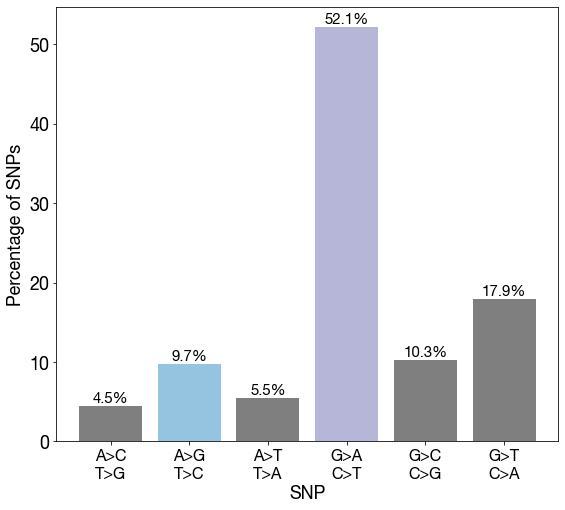

In [25]:
plt.figure(figsize=(9,8))
a, b=[plt.cm.Blues, plt.cm.Purples]
c_list = ['tab:grey', a(0.4),'tab:grey',b(0.4),'tab:grey','tab:grey']
plt.bar(labels, 100*np.asarray(compact)/np.sum(np.asarray(compact)), color=c_list)
plt.xticks(fontsize=16);
plt.yticks(fontsize=18);
plt.ylabel('Percentage of SNPs', fontsize=18);
plt.xlabel('SNP', fontsize=18);

perc = 100*np.asarray(compact)/np.sum(np.asarray(compact))

for i in range(6):
    plt.text(i, perc[i]+0.5, str(np.round(perc[i], 1)) + '%', ha = 'center', fontsize=15)
 
plt.savefig('SNP_breakdown2.png', dpi=300)

In [56]:
snp_count[list(uniq).index('A>T')]

10598

In [23]:
sum(snp_count) + len(unknown)

348145

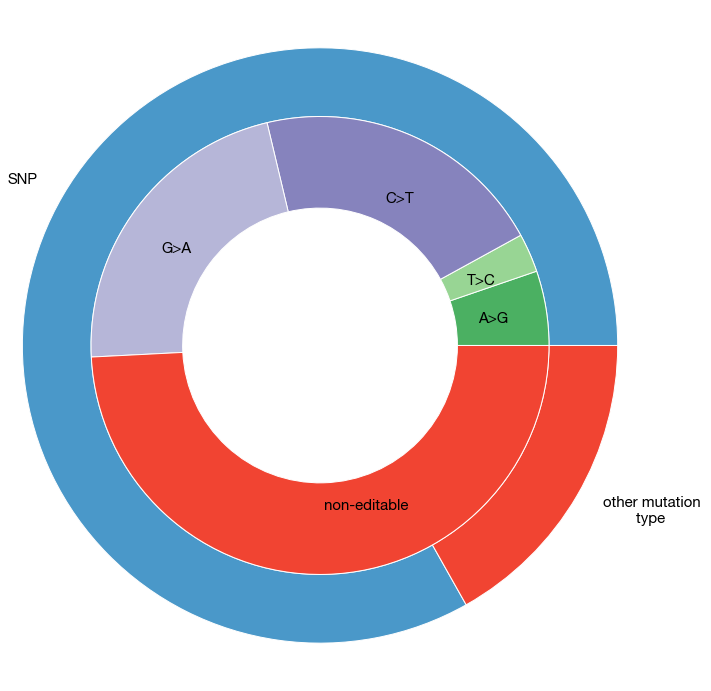

In [72]:
# Make data: I have 3 groups and 7 subgroups
group_names=['SNP', 'other mutation \n        type'] #
snp_unrecorded=unknown
group_size=[mut_types[0]-len(snp_unrecorded), sum(mut_types)-mut_types[0]-len(snp_unrecorded)] #excluding missing SNPs
subgroup_names=['A>G', 'T>C','C>T', 'G>A', 'non-editable']
sum1 = snp_count[list(uniq).index('A>G')]+snp_count[list(uniq).index('T>C')]+snp_count[list(uniq).index('C>T')]+snp_count[list(uniq).index('G>A')]
subgroup_size = [snp_count[list(uniq).index('A>G')],snp_count[list(uniq).index('T>C')],snp_count[list(uniq).index('C>T')],snp_count[list(uniq).index('G>A')], sum(mut_types)-sum1-len(snp_unrecorded)]
#subgroup_size=[4,3,5,6,5,10,5,5,4,6]
 
# Create colors
a, b, c, d=[plt.cm.Blues, plt.cm.Reds, plt.cm.Greens, plt.cm.Purples]
 
# First Ring (outside)
fig, ax = plt.subplots(figsize=(10,10))
ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=1.3, labels=group_names, colors=[a(0.6), b(0.6), c(0.6)], textprops={'fontsize': 15})
plt.setp( mypie, width=0.3, edgecolor='white')
 
# Second Ring (Inside)
mypie2, _ = ax.pie(subgroup_size, radius=1.3-0.3, labels=subgroup_names, labeldistance=0.7, colors=[c(0.6), c(0.4), d(0.6), d(0.4), b(0.6)], textprops={'fontsize': 15})
plt.setp( mypie2, width=0.4, edgecolor='white')
plt.margins(0,0)
 
# show it
plt.tight_layout()
plt.show()

#fig.savefig('access.png', dpi=200)

In [5]:
#loading in coverage information
filepath = '/Volumes/Sam_G_SSD/BE coverage quant NGG/'
CBEproto = np.load(filepath + 'CBE_proto.npy')
CBEideal = np.load(filepath + 'CBE_ideal.npy')
ABEproto = np.load(filepath + 'ABE_proto.npy')
ABEideal = np.load(filepath + 'ABE_ideal.npy')

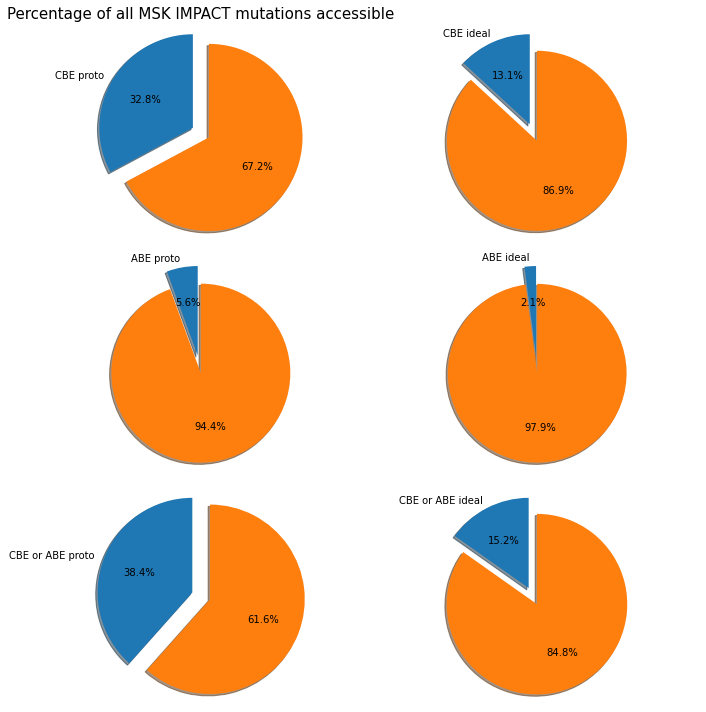

In [6]:
cprot = sum(CBEproto)/ (len(impact_data))


labels1 = ['CBE proto', '']
labels2 = ['CBE ideal', '']
labels3 = ['ABE proto', '']
labels4 = ['ABE ideal', '']
labels5 = ['CBE or ABE proto', '']
labels6 = ['CBE or ABE ideal', '']

sizes1 = [sum(CBEproto), (len(impact_data))-sum(CBEproto)]
sizes2 = [sum(CBEideal), (len(impact_data))-sum(CBEideal)]
sizes3 = [sum(ABEproto), (len(impact_data))-sum(ABEproto)]
sizes4 = [sum(ABEideal), (len(impact_data))-sum(ABEideal)]
sizes5 = [sum(ABEproto)+sum(CBEproto), (len(impact_data))-(sum(ABEproto)+sum(CBEproto))]
sizes6 = [sum(ABEideal)+sum(CBEideal), (len(impact_data))-(sum(ABEideal)+sum(CBEideal))]



explode = (0.1, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(3, 2, figsize=(10,10))
ax1[0][0].set_title('Percentage of all MSK IMPACT mutations accessible', fontsize=15)


ax1[0][0].pie(sizes1, explode=explode, labels=labels1, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1[0][0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

ax1[0][1].pie(sizes2, explode=explode, labels=labels2, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1[0][1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

ax1[1][0].pie(sizes3, explode=explode, labels=labels3, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1[1][0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

ax1[1][1].pie(sizes4, explode=explode, labels=labels4, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1[1][1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

ax1[2][0].pie(sizes5, explode=explode, labels=labels5, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1[2][0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

ax1[2][1].pie(sizes6, explode=explode, labels=labels6, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1[2][1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.tight_layout()
plt.show()
#fig1.savefig('Pie_mutation_rep.png', dpi=200)
#fig1.savefig('allMuts_accessibleTERTincl.png', dpi=200)

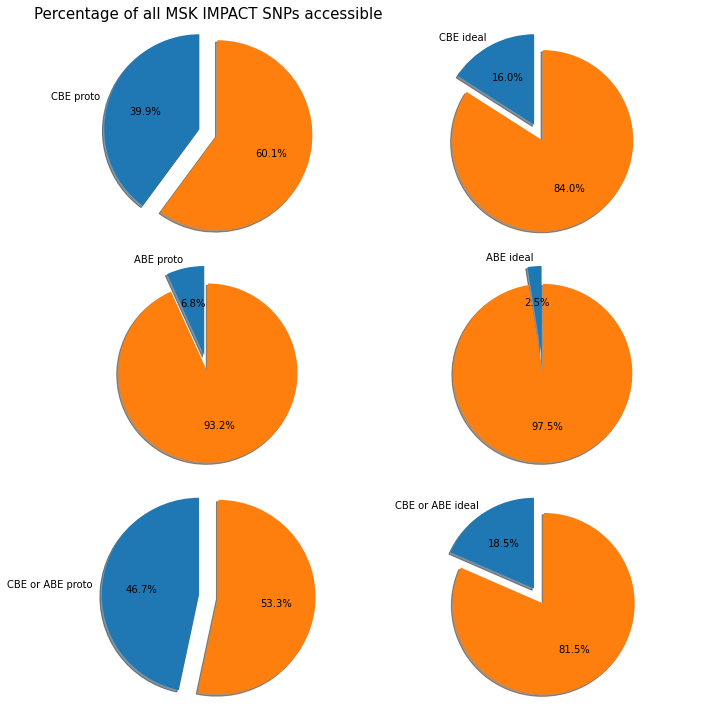

In [7]:

labels1 = ['CBE proto', '']
labels2 = ['CBE ideal', '']
labels3 = ['ABE proto', '']
labels4 = ['ABE ideal', '']
labels5 = ['CBE or ABE proto', '']
labels6 = ['CBE or ABE ideal', '']

sizes1 = [sum(CBEproto), ((mut_types[0]))-sum(CBEproto)]
sizes2 = [sum(CBEideal), ((mut_types[0]))-sum(CBEideal)]
sizes3 = [sum(ABEproto), ((mut_types[0]))-sum(ABEproto)]
sizes4 = [sum(ABEideal), ((mut_types[0]))-sum(ABEideal)]
sizes5 = [sum(ABEproto)+sum(CBEproto), ((mut_types[0]))-(sum(ABEproto)+sum(CBEproto))]
sizes6 = [sum(ABEideal)+sum(CBEideal), ((mut_types[0]))-(sum(ABEideal)+sum(CBEideal))]



explode = (0.1, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(3, 2, figsize=(10,10))

ax1[0][0].set_title('Percentage of all MSK IMPACT SNPs accessible', fontsize=15)



ax1[0][0].pie(sizes1, explode=explode, labels=labels1, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1[0][0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

ax1[0][1].pie(sizes2, explode=explode, labels=labels2, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1[0][1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

ax1[1][0].pie(sizes3, explode=explode, labels=labels3, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1[1][0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

ax1[1][1].pie(sizes4, explode=explode, labels=labels4, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1[1][1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

ax1[2][0].pie(sizes5, explode=explode, labels=labels5, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1[2][0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

ax1[2][1].pie(sizes6, explode=explode, labels=labels6, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1[2][1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.tight_layout()
plt.show()
#fig1.savefig('SNPs_accessibleTERTincl.png', dpi=200)

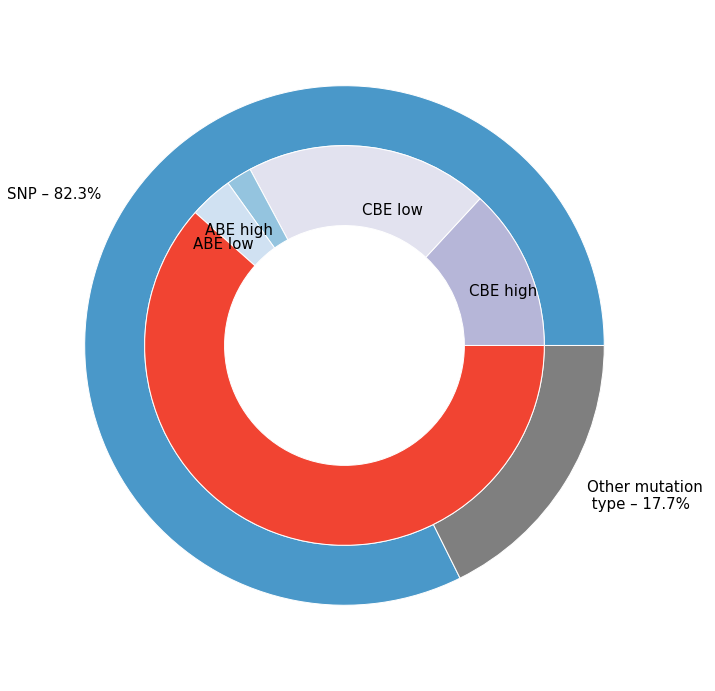

In [13]:
#loading in coverage information
filepath = '/Volumes/Sam_G_SSD/BE coverage quant NGG/'
CBEproto = np.load(filepath + 'CBE_proto.npy')
CBEideal = np.load(filepath + 'CBE_ideal.npy')
ABEproto = np.load(filepath + 'ABE_proto.npy')
ABEideal = np.load(filepath + 'ABE_ideal.npy')

# Make data: I have 3 groups and 7 subgroups
group_names=['SNP – 82.3%', 'Other mutation \n type – 17.7%'] #
#group_names=['', '']
snp_unrecorded = []
group_size=[mut_types[0]-len(snp_unrecorded), sum(mut_types)-mut_types[0]-len(snp_unrecorded)] #excluding missing SNPs
subgroup_names=['CBE high', 'CBE low', 'ABE high', 'ABE low', '']
#subgroup_names=['', '', '', '', '']

subgroup_size = [sum(CBEideal), sum(CBEproto)-sum(CBEideal), sum(ABEideal), sum(ABEproto)-sum(ABEideal), sum(mut_types)-sum(CBEproto)-sum(ABEproto)-len(snp_unrecorded)]
#subgroup_size=[4,3,5,6,5,10,5,5,4,6]
 
# Create colors
a, b, c, d=[plt.cm.Blues, plt.cm.Reds, plt.cm.Greens, plt.cm.Purples]
 
# First Ring (outside)
fig, ax = plt.subplots(figsize=(10,10))
ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=1.3, labels=group_names, colors=[a(0.6), 'tab:gray', c(0.6)], textprops={'fontsize': 15})
plt.setp( mypie, width=0.3, edgecolor='white')
 
# Second Ring (Inside)
mypie2, _ = ax.pie(subgroup_size, radius=1.3-0.3, labels=subgroup_names, labeldistance=0.68, colors=[d(0.4), d(0.2), a(0.4), a(0.2), b(0.6)], textprops={'fontsize': 15})
plt.setp( mypie2, width=0.4, edgecolor='white')
plt.margins(0,0)
 
# show it
plt.tight_layout()
plt.show()

#fig.savefig('BE_donut_human_NGG_nolabels.png', dpi=250)

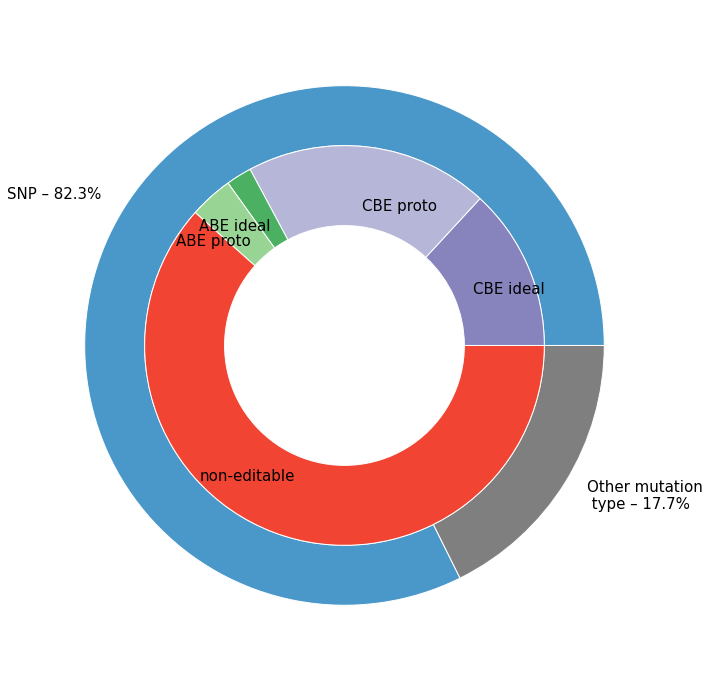

In [12]:
# Make data: I have 3 groups and 7 subgroups
group_names=['SNP – 82.3%', 'Other mutation \n type – 17.7%'] #
snp_unrecorded = []
group_size=[mut_types[0]-len(snp_unrecorded), sum(mut_types)-mut_types[0]-len(snp_unrecorded)] #excluding missing SNPs
subgroup_names=['CBE ideal', 'CBE proto', 'ABE ideal', 'ABE proto', 'non-editable']

subgroup_size = [sum(CBEideal), sum(CBEproto)-sum(CBEideal), sum(ABEideal), sum(ABEproto)-sum(ABEideal), sum(mut_types)-sum(CBEproto)-sum(ABEproto)-len(snp_unrecorded)]
#subgroup_size=[4,3,5,6,5,10,5,5,4,6]
 
# Create colors
a, b, c, d=[plt.cm.Blues, plt.cm.Reds, plt.cm.Greens, plt.cm.Purples]
 
# First Ring (outside)
fig, ax = plt.subplots(figsize=(10,10))
ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=1.3, labels=group_names, colors=[a(0.6), 'tab:gray', c(0.6)], textprops={'fontsize': 15})
plt.setp( mypie, width=0.3, edgecolor='white')
 
# Second Ring (Inside)
mypie2, _ = ax.pie(subgroup_size, radius=1.3-0.3, labels=subgroup_names, labeldistance=0.7, colors=[d(0.6), d(0.4), c(0.6), c(0.4), b(0.6)], textprops={'fontsize': 15})
plt.setp( mypie2, width=0.4, edgecolor='white')
plt.margins(0,0)
 
# show it
plt.tight_layout()
plt.show()

#fig.savefig('donut_plot.png', dpi=200)